In [485]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from enum import Enum
from ngboost.scores import LogScore
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from ngboost.distns import Exponential, Normal, LogNormal
from ngboost.scores import LogScore, CRPScore
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import ephem
from datetime import datetime
import pickle
from pathlib import Path
import pypsa

paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv",
         "era5_regions": "resources/europe-2013-era5-regions.nc",
         "res_pypsa_q40": "resources/pypsa/results/networks/elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc",
         "res_pypsa_q60": "resources/pypsa/results/networks/elec_s_37_q60_ec_lv1.0_Co2L0.0-1H.nc",
         "res_pypsa_qo": "resources/pypsa/results/networks/elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc"}

In [486]:
ds = xr.open_dataset(filename_or_obj=paths["era5_regions"], engine="netcdf4")
capfacts = pd.read_csv(paths["capfacs"])

capfacts_pred_q30 = pd.read_csv("results/capfacts_pred_q30.csv", index_col=0)
capfacts_pred_q30_clipped = pd.read_csv("results/capfacts_pred_q30_clipped.csv", index_col=0)

capfacts_pred_q35 = pd.read_csv("results/capfacts_pred_q35.csv", index_col=0)
capfacts_pred_q35_clipped = pd.read_csv("results/capfacts_pred_q35_clipped.csv", index_col=0)

capfacts_pred_q40 = pd.read_csv("results/capfacts_pred_q40.csv", index_col=0)
capfacts_pred_q40_clipped = pd.read_csv("results/capfacts_pred_q40_clipped.csv", index_col=0)

capfacts_pred_q45 = pd.read_csv("results/capfacts_pred_q45.csv", index_col=0)
capfacts_pred_q45_clipped = pd.read_csv("results/capfacts_pred_q45_clipped.csv", index_col=0)

capfacts_pred_q50 = pd.read_csv("results/capfacts_pred_q45.csv", index_col=0)
capfacts_pred_q50_clipped = pd.read_csv("results/capfacts_pred_q45_clipped.csv", index_col=0)

capfacts_pred_q55 = pd.read_csv("results/capfacts_pred_q55.csv", index_col=0)
capfacts_pred_q55_clipped = pd.read_csv("results/capfacts_pred_q55_clipped.csv", index_col=0)

capfacts_pred_q60 = pd.read_csv("results/capfacts_pred_q60.csv", index_col=0)
capfacts_pred_q60_clipped = pd.read_csv("results/capfacts_pred_q60_clipped.csv", index_col=0)

capfacts_pred_q65 = pd.read_csv("results/capfacts_pred_q65.csv", index_col=0)
capfacts_pred_q65_clipped = pd.read_csv("results/capfacts_pred_q65_clipped.csv", index_col=0)

capfacts_pred_q70 = pd.read_csv("results/capfacts_pred_q65.csv", index_col=0)
capfacts_pred_q70_clipped = pd.read_csv("results/capfacts_pred_q65_clipped.csv", index_col=0)

In [487]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

class EnergyType(Enum):
    """
    Represents the different type of renewable energy sources in pypsa-eur
    """
    OFFWIND_AC = "offwind-ac"
    OFFWIND_DC = "offwind-dc"
    OFFWIND = "offwind"
    ONWIND = "onwind"
    WIND = "wind"
    SOLAR = "solar"
    ROR = "ror"
    NOT_DEFINED = "not_defined"

class Feature(Enum):
    """
    Represents the features, that can be extracted from the era-5 weather data set
    """
    HEIGHT = "height"
    WND100M = "wnd100m"
    ROUGHNESS = "roughness"
    INFLUX_TOA = "influx_toa"
    INFLUX_DIRECT = "influx_direct"
    INFLUX_DIFFUSE = "influx_diffuse"
    ALBEDO = "albedo"
    TEMPERATURE = "temperature"
    SOIL_TEMPERATURE = "soil_temperature"
    RUNOFF = "runoff"

"""
Determines which features are selected to calculate the capacity factor of a certain energy type.
"""
feature_set = {
    EnergyType.OFFWIND_AC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.OFFWIND_DC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.ONWIND: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.SOLAR: [Feature.INFLUX_TOA, Feature.INFLUX_DIRECT, Feature.INFLUX_DIFFUSE, Feature.TEMPERATURE],
    EnergyType.ROR: []
}

def filter_by_energy_type(df: pd.DataFrame, energy_type: EnergyType) -> pd.DataFrame:
    re=".*"
    match energy_type:
        case EnergyType.SOLAR:
            re = ".*solar"
        case EnergyType.OFFWIND_AC:
            re = ".*offwind-ac"
        case EnergyType.OFFWIND_DC:
            re = ".*offwind-dc"
        case EnergyType.ONWIND:
            re = ".*onwind"
        case EnergyType.WIND:
            re = ".*(offwind-ac|offwind-dc|onwind)"
        case EnergyType.OFFWIND:
            re = ".*(offwind-ac|offwind-dc)"
    return df.filter(regex=re)


def find_countries_in_capfacts(country_name="") -> list:
    """
    Returns the full region names and energy types of the given name abbreviation that can be found in the .csv file with capacity factors.
    :param country_name: Two character abbreviation of the searched country
    :return: list of all regions and energy types to the given country name
    """
    countries = []
    for column in capfacts:
        if column.find(country_name) >= 0:
            countries.append(column)
    return countries


def get_energy_type(name: str) -> EnergyType:
    """
    Returns the energy type for a given string
    :param name: energy type as string
    :return: energy type for the given string
    """
    match name:
        case "offwind-ac":
            return EnergyType.OFFWIND_AC
        case "offwind-dc":
            return EnergyType.OFFWIND_DC
        case "onwind":
            return EnergyType.ONWIND
        case "solar":
            return EnergyType.SOLAR
        case "ror":
            return EnergyType.ROR
        case _:
            return EnergyType.NOT_DEFINED

def get_ds_region_name(region_name: str, energy_type: EnergyType) -> str:
    """
    Returns the name or string that addresses the given region and energy type which can be used to address the data in the feature data set
    :param region_name: name of the region
    :param energy_type: the uses energy type in that region
    :return: string that can be used to fetch data from the feature data set
    """
    ds_region_name = region_name + " 0"
    if energy_type == EnergyType.ONWIND or energy_type == EnergyType.SOLAR or energy_type == EnergyType.ROR:
        ds_region_name += " on"
    elif energy_type == EnergyType.OFFWIND_AC or energy_type == EnergyType.OFFWIND_DC:
        ds_region_name += " off"
    else:
        ds_region_name += ""
    return ds_region_name

def parse_capfac_col(column_name: str) -> (str, EnergyType):
    """
    Returns a tuple of the region name and energy type for a given column name of the capfacts .csv file
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of a region name and energy type, None if no region is found
    """
    col_args = column_name.split(" ")
    if len(col_args) == 3:
        region_name = col_args[0]
        energy_type = get_energy_type(col_args[2])
        return region_name, energy_type
    return None, None

def create_training_data_for_col(column_name: str) -> (np.ndarray, dict):
    """
    Creates and returns the the training data set with the relevant data for a given column name from the capfacts .csv file.
    The training data set is a tuple of a numpy array of capacity factors (target values) and a dictionary of the era5 data (feature data),
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of capacity factor (Y) and trainings data (X)
            X                       : DataFrame object or List or numpy array of predictors (n x p) in Numeric format
            Y                       : DataFrame object or List or numpy array of outcomes (n) in Numeric format.
    """
    region_name, energy_type = parse_capfac_col(column_name)
    # print(region_name)
    # print(energy_type)
    ds_region_name = get_ds_region_name(region_name, energy_type)
    # print(ds_region_name)
    features = feature_set.get(energy_type)
    # print(features)

    Y_capfac = capfacts[column_name].values
    X = {}
    for feature in features:
        X[feature] = ds.sel(region=ds_region_name)[feature.value].values

    return Y_capfac, X


def shape_multi_feature_data(training_data: dict):
    """
    Reshapes the trainingsdata in an array of shape (n_samples, n_features)
    (8760, 2) ---> [[x_f1_1, x_f2_1], [x_f1_2, x_f2_2], ... , [x_f1_8760, x_f2_8760]]
    :param training_data as a dictinary of multiple 1-d arrays:
    :return: trainingsdata in array of shape (n_samples,  n_features)
    """
    # tup = tuple(list(training_data.values()))
    # multi_feature_train_data = np.column_stack(tup)
    arrays = list(training_data.values())
    return np.stack(arrays, axis=-1)

## Capacity Factors Mean

In [488]:
regions = capfacts_pred_q40.columns.values[1:]

idx_names = ["real_mean", "q50_mean", "q50_clipped_mean", "q40_mean", "q40_clipped_mean","q60_mean", "q60_clipped_mean", "q30_mean", "q30_clipped_mean","q70_mean", "q70_clipped_mean", "10% confidence", "20% confidence", "30% confidence", "40% confidence"]
idx = dict(zip(idx_names, idx_names))
capfacts_analysis = pd.DataFrame(index = idx)

new_columns = {}

for region in regions:
    values = {}
    values[idx["real_mean"]] = capfacts[region].mean()
    values[idx["q40_mean"]] = capfacts_pred_q40[region].mean()
    values[idx["q60_mean"]] = capfacts_pred_q40[region].mean()
    values[idx["q40_clipped_mean"]] = capfacts_pred_q40_clipped[region].mean()
    values[idx["q60_clipped_mean"]] = capfacts_pred_q60_clipped[region].mean()
    values[idx["q30_mean"]] = capfacts_pred_q30[region].mean()
    values[idx["q70_mean"]] = capfacts_pred_q70[region].mean()
    values[idx["q30_clipped_mean"]] = capfacts_pred_q30_clipped[region].mean()
    values[idx["q70_clipped_mean"]] = capfacts_pred_q70_clipped[region].mean()
    values[idx["q50_mean"]] = capfacts_pred_q50[region].mean()
    values[idx["q50_clipped_mean"]] = capfacts_pred_q50_clipped[region].mean()
    values[idx["10% confidence"]] = coverage_fraction(capfacts[region], capfacts_pred_q45[region], capfacts_pred_q55[region])
    values[idx["20% confidence"]] = coverage_fraction(capfacts[region], capfacts_pred_q40[region], capfacts_pred_q60[region])
    values[idx["30% confidence"]] = coverage_fraction(capfacts[region], capfacts_pred_q35[region], capfacts_pred_q65[region])
    values[idx["40% confidence"]] = coverage_fraction(capfacts[region], capfacts_pred_q30[region], capfacts_pred_q70[region])

    new_columns[region] = pd.Series(values)

new_columns = pd.DataFrame(new_columns, index=capfacts_analysis.index)
capfacts_analysis = pd.concat([capfacts_analysis, new_columns], axis = 1)
capfacts_analysis

,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,BE0 0 onwind,...,RS0 0 solar,SE4 0 offwind-ac,SE4 0 offwind-dc,SE4 0 onwind,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
real_mean,0.144222,0.059075,0.131122,0.133949,0.102517,0.047873,0.113904,0.461893,0.520243,0.290474,...,0.116954,0.411495,0.497266,0.221257,0.095503,0.127760,0.057465,0.106495,0.142276,0.104567
q50_mean,0.140598,0.056314,0.125823,0.129629,0.098322,0.046221,0.109410,0.456739,0.515304,0.286649,...,0.112709,0.403349,0.482674,0.216055,0.091121,0.127070,0.055942,0.101920,0.136289,0.100818
q50_clipped_mean,0.140600,0.056322,0.126259,0.129633,0.098595,0.046221,0.109948,0.456741,0.515304,0.286650,...,0.113025,0.403349,0.482674,0.216055,0.091496,0.127075,0.055954,0.102280,0.136325,0.101125
q40_mean,0.135868,0.053726,0.120949,0.125559,0.094300,0.044585,0.105098,0.451567,0.509519,0.282438,...,0.108526,0.394941,0.468411,0.211098,0.086382,0.126285,0.054406,0.097240,0.131129,0.096590
q40_clipped_mean,0.135871,0.053739,0.121466,0.125565,0.094620,0.044585,0.105723,0.451653,0.509521,0.282440,...,0.108908,0.394941,0.468411,0.211098,0.086841,0.126340,0.054428,0.097676,0.131175,0.096950
q60_mean,0.135868,0.053726,0.120949,0.125559,0.094300,0.044585,0.105098,0.451567,0.509519,0.282438,...,0.108526,0.394941,0.468411,0.211098,0.086382,0.126285,0.054406,0.097240,0.131129,0.096590
q60_clipped_mean,0.154630,0.063997,0.140524,0.141714,0.110433,0.051078,0.122543,0.472094,0.532475,0.299149,...,0.125284,0.428517,0.525020,0.230769,0.105387,0.129396,0.060501,0.116025,0.151622,0.113523
q30_mean,0.125834,0.048233,0.110604,0.116918,0.085761,0.041111,0.095971,0.440585,0.497238,0.273499,...,0.099646,0.376761,0.438126,0.200575,0.076325,0.124621,0.051146,0.087299,0.120176,0.087628
q30_clipped_mean,0.125858,0.048271,0.111376,0.116938,0.086218,0.041120,0.096831,0.441057,0.497426,0.273509,...,0.100237,0.376761,0.438129,0.200575,0.077066,0.124811,0.051202,0.088004,0.120252,0.088149
q70_mean,0.159518,0.066670,0.145325,0.145919,0.114420,0.052770,0.126651,0.477440,0.538457,0.303502,...,0.129448,0.437423,0.539764,0.235893,0.110081,0.130207,0.062088,0.120662,0.156937,0.117723


### Mean value

In [489]:
eval_mean = capfacts_analysis.loc[["q30_clipped_mean","q40_clipped_mean", "real_mean", "q60_clipped_mean", "q70_clipped_mean"]].mean(axis=1)
eval_mean_df = pd.concat([eval_mean], axis=1)
eval_mean_df.set_axis(["30 %", "40 %", "original", "60 %", "70 %"], axis="index", inplace=True)
eval_mean_df.set_axis(["mean"], axis=1, inplace=True)
eval_mean_df

,mean
30 %,0.220150
40 %,0.235986
original,0.250681
60 %,0.265662
70 %,0.273397


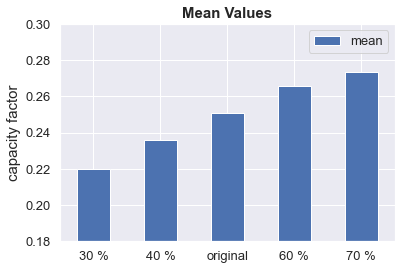

In [490]:
eval_mean_df.plot.bar(xlabel="", ylim=(0.18, 0.3))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.title("Mean Values", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/mean_values.png", bbox_inches="tight")
plt.show()

### Coverage Plots

In [491]:
eval_coverage = capfacts_analysis.loc[["10% confidence", "20% confidence", "30% confidence", "40% confidence"]]
eval_coverage

,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,BE0 0 onwind,...,RS0 0 solar,SE4 0 offwind-ac,SE4 0 offwind-dc,SE4 0 onwind,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
10% confidence,0.083562,0.076256,0.086986,0.095205,0.170890,0.082877,0.105708,0.151826,0.121918,0.100228,...,0.094178,0.078767,0.085502,0.092808,0.050457,0.231621,0.107763,0.105479,0.094178,0.049315
20% confidence,0.184361,0.167580,0.164840,0.193836,0.221233,0.174315,0.230365,0.366324,0.357306,0.200228,...,0.207534,0.162215,0.164041,0.182763,0.147831,0.524658,0.199315,0.168950,0.186758,0.098288
30% confidence,0.272603,0.251712,0.258676,0.289840,0.285046,0.261644,0.294521,0.481393,0.489954,0.303311,...,0.298402,0.256164,0.253767,0.281849,0.216210,0.613470,0.297717,0.307420,0.284361,0.212215
40% confidence,0.334703,0.309703,0.299772,0.345776,0.351370,0.354909,0.319406,0.537557,0.546575,0.366096,...,0.333105,0.311416,0.307306,0.344863,0.253767,0.656507,0.363927,0.339840,0.359589,0.239041


In [492]:
coverage_wind = filter_by_energy_type(eval_coverage, EnergyType.WIND).mean(axis=1)
coverage_onwind = filter_by_energy_type(eval_coverage, EnergyType.ONWIND).mean(axis=1)
coverage_offwind = filter_by_energy_type(eval_coverage, EnergyType.OFFWIND).mean(axis=1)
coverage_solar = filter_by_energy_type(eval_coverage, EnergyType.SOLAR).mean(axis=1)
coverage_total = eval_coverage.mean(axis=1)
eval_coverage_df = pd.concat([coverage_wind, coverage_solar, coverage_total], axis=1)
eval_coverage_df.set_axis(["10 %", "20 % ", "30 % ", "40 % "], axis="index", inplace=True)
eval_coverage_df.set_axis(["Wind", "Solar", "Total"], axis=1, inplace=True)
eval_coverage_df

,Wind,Solar,Total
10 %,0.095365,0.082044,0.091422
20 %,0.197051,0.158321,0.185587
30 %,0.299253,0.244915,0.283169
40 %,0.361733,0.300787,0.343693


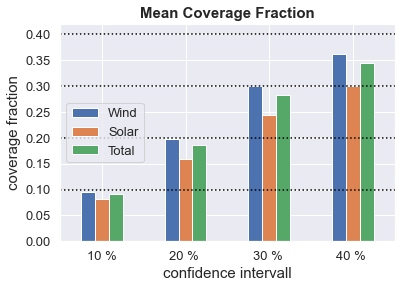

In [493]:
eval_coverage_df.plot.bar()
plt.axhline(y = 0.1, color = 'black', linestyle = 'dotted')
plt.axhline(y = 0.2, color = 'black', linestyle = 'dotted')
plt.axhline(y = 0.3, color = 'black', linestyle = 'dotted')
plt.axhline(y = 0.4, color = 'black', linestyle = 'dotted')
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("coverage fraction", fontsize=15)
plt.xlabel("confidence intervall", fontsize=15)
plt.title("Mean Coverage Fraction", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/mean_coverage.png", bbox_inches="tight")
plt.show()

In [494]:
coverage_total = eval_coverage.mean(axis=1)
eval_coverage_dfw = pd.concat([coverage_onwind, coverage_offwind, coverage_solar, coverage_total], axis=1)
eval_coverage_dfw.set_axis(["10 %", "20 % ", "30 % ", "40 % "], axis="index", inplace=True)
eval_coverage_dfw.set_axis(["Wind onshore", "Wind offshore", "Solar", "Total"], axis=1, inplace=True)
eval_coverage_dfw

,Wind onshore,Wind offshore,Solar,Total
10 %,0.097643,0.093713,0.082044,0.091422
20 %,0.198183,0.196231,0.158321,0.185587
30 %,0.304014,0.295799,0.244915,0.283169
40 %,0.370289,0.355526,0.300787,0.343693


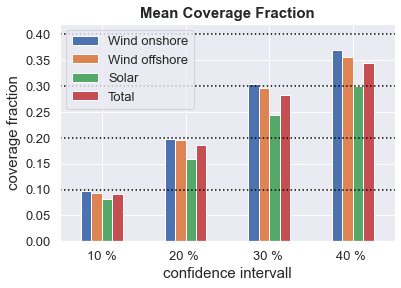

In [495]:
eval_coverage_dfw.plot.bar()
plt.axhline(y = 0.1, color = 'black', linestyle = 'dotted')
plt.axhline(y = 0.2, color = 'black', linestyle = 'dotted')
plt.axhline(y = 0.3, color = 'black', linestyle = 'dotted')
plt.axhline(y = 0.4, color = 'black', linestyle = 'dotted')
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("coverage fraction", fontsize=15)
plt.xlabel("confidence intervall", fontsize=15)
plt.title("Mean Coverage Fraction", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/mean_coverage_2.png", bbox_inches="tight")
plt.show()

### Capacity factor profiles + duration curves
#### Solar

In [496]:
capfacts

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,...,SE4 0 onwind,SE4 0 ror,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 ror,SI0 0 solar,SK0 0 onwind,SK0 0 ror,SK0 0 solar
0,2013-01-01 00:00:00,0.003291,0.001469,0.0,0.163262,0.224456,0.0,0.007340,0.0,1.000000,...,0.459609,0.626955,0.0,0.000000,0.055146,0.344668,0.0,0.361009,0.106197,0.0
1,2013-01-01 01:00:00,0.002103,0.000000,0.0,0.171340,0.224369,0.0,0.007939,0.0,0.999998,...,0.463265,0.625502,0.0,0.000000,0.052605,0.344657,0.0,0.368912,0.106012,0.0
2,2013-01-01 02:00:00,0.000000,0.000000,0.0,0.171035,0.224300,0.0,0.007829,0.0,0.993941,...,0.463777,0.624810,0.0,0.000000,0.052222,0.344593,0.0,0.382949,0.105968,0.0
3,2013-01-01 03:00:00,0.000000,0.000000,0.0,0.169685,0.224249,0.0,0.005766,0.0,0.916094,...,0.463041,0.623794,0.0,0.000000,0.050762,0.344626,0.0,0.388344,0.106215,0.0
4,2013-01-01 04:00:00,0.000000,0.000000,0.0,0.159757,0.224213,0.0,0.004262,0.0,0.704786,...,0.457253,0.623085,0.0,0.000000,0.047285,0.344607,0.0,0.409303,0.106364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029235,0.024321,0.0,0.109127,0.275353,0.0,0.001076,0.0,0.998922,...,0.358191,0.469586,0.0,0.027877,0.001708,0.696975,0.0,0.125735,0.157729,0.0
8756,2013-12-31 20:00:00,0.034024,0.031357,0.0,0.120485,0.275159,0.0,0.001090,0.0,0.965757,...,0.324709,0.469395,0.0,0.023567,0.000000,0.696262,0.0,0.142431,0.157817,0.0
8757,2013-12-31 21:00:00,0.037104,0.034522,0.0,0.128186,0.274975,0.0,0.001062,0.0,0.852484,...,0.288415,0.469208,0.0,0.000000,0.004891,0.695524,0.0,0.153930,0.157899,0.0
8758,2013-12-31 22:00:00,0.029730,0.027419,0.0,0.124740,0.274784,0.0,0.001351,0.0,0.776442,...,0.268695,0.469028,0.0,0.000000,0.009091,0.694665,0.0,0.163442,0.157945,0.0


In [497]:
solar_o = filter_by_energy_type(capfacts, EnergyType.SOLAR).mean(axis=1)
solar30 = filter_by_energy_type(capfacts_pred_q30_clipped, EnergyType.SOLAR).mean(axis=1)
solar40 = filter_by_energy_type(capfacts_pred_q40_clipped, EnergyType.SOLAR).mean(axis=1)
solar50 = filter_by_energy_type(capfacts_pred_q50_clipped, EnergyType.SOLAR).mean(axis=1)
solar60 = filter_by_energy_type(capfacts_pred_q60_clipped, EnergyType.SOLAR).mean(axis=1)
solar70 = filter_by_energy_type(capfacts_pred_q70_clipped, EnergyType.SOLAR).mean(axis=1)
# solar = pd.concat([solar_o, solar30, solar40, solar50, solar60, solar70], axis=1)
# solar = pd.concat([solar_o, solar40, solar50, solar60], axis=1)
solar = pd.concat([solar_o, solar50], axis=1)
# solar.set_axis(["original", "30 %", "40 %", "50 %", "60 %", "70 %"], axis=1, inplace=True)
# solar.set_axis(["original", "40 %", "50 %", "60 %"], axis=1, inplace=True)
solar.set_axis(["original", "50 %"], axis=1, inplace=True)
solar["Datetime"] = pd.to_datetime(capfacts.snapshot, format="%Y-%m-%d %H:%M:%S")
solar.set_index("Datetime", inplace=True)
# solar["Datetime"] = pd.to_datetime(capfacts.snapshot, format="%Y-%m-%d %H:%M:%S")
# solar.set_index(pd.DatetimeIndex(solar["Datetime"]))
# solar.plot()

solar

,original,50 %
Datetime,,
2013-01-01 00:00:00,0.0,0.001510
2013-01-01 01:00:00,0.0,0.001464
2013-01-01 02:00:00,0.0,0.001501
2013-01-01 03:00:00,0.0,0.001547
2013-01-01 04:00:00,0.0,0.001529
...,...,...
2013-12-31 19:00:00,0.0,0.001352
2013-12-31 20:00:00,0.0,0.001406
2013-12-31 21:00:00,0.0,0.001612


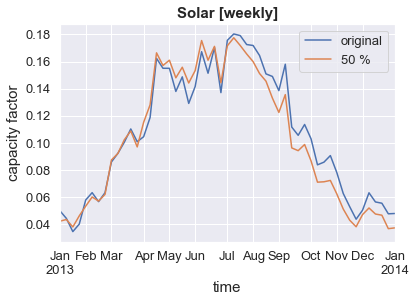

In [498]:
solar_daily = solar.resample(rule="W").mean()
solar_daily.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time", fontsize=15)
plt.title("Solar [weekly]", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/solar_weekly.png", bbox_inches="tight")
plt.show()

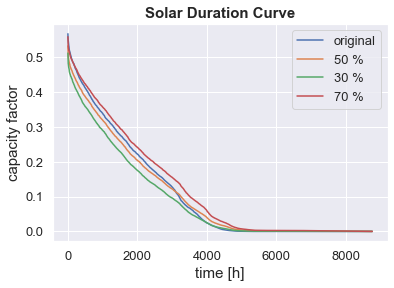

In [499]:
solar_o_duration = pd.Series(np.sort(solar_o)[::-1])
solar_50_duration = pd.Series(np.sort(solar50)[::-1])
solar_30_duration = pd.Series(np.sort(solar30)[::-1])
solar_70_duration = pd.Series(np.sort(solar70)[::-1])
solar_duration = pd.concat([solar_o_duration, solar_50_duration, solar_30_duration, solar_70_duration], axis=1)
solar_duration.set_axis(["original", "50 %", "30 %", "70 %", ], axis=1, inplace=True)
# solar_duration["Datetime"] = pd.to_datetime(capfacts.snapshot, format="%Y-%m-%d %H:%M:%S")
# solar_duration.set_index("Datetime", inplace=True)


solar_duration.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time [h]", fontsize=15)
plt.title("Solar Duration Curve", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/solar_duration.png", bbox_inches="tight")
plt.show()

#### Wind

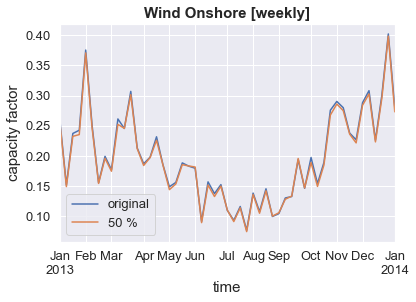

In [500]:
onwind_o = filter_by_energy_type(capfacts, EnergyType.ONWIND).mean(axis=1)
onwind30 = filter_by_energy_type(capfacts_pred_q30_clipped, EnergyType.ONWIND).mean(axis=1)
onwind40 = filter_by_energy_type(capfacts_pred_q40_clipped, EnergyType.ONWIND).mean(axis=1)
onwind50 = filter_by_energy_type(capfacts_pred_q50_clipped, EnergyType.ONWIND).mean(axis=1)
onwind60 = filter_by_energy_type(capfacts_pred_q60_clipped, EnergyType.ONWIND).mean(axis=1)
onwind70 = filter_by_energy_type(capfacts_pred_q70_clipped, EnergyType.ONWIND).mean(axis=1)
onwind = pd.concat([onwind_o, onwind50], axis=1)
onwind.set_axis(["original", "50 %"], axis=1, inplace=True)
onwind["Datetime"] = pd.to_datetime(capfacts.snapshot, format="%Y-%m-%d %H:%M:%S")
onwind.set_index("Datetime", inplace=True)

onwind_daily = onwind.resample(rule="W").mean()
onwind_daily.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time", fontsize=15)
plt.title("Wind Onshore [weekly]", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/wind_onshore_weekly.png", bbox_inches="tight")
plt.show()

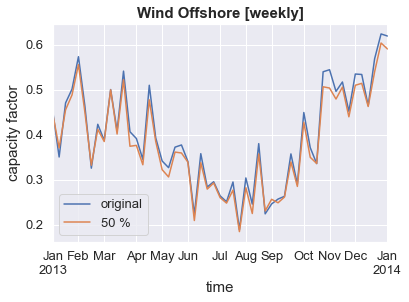

In [501]:
offwind_o = filter_by_energy_type(capfacts, EnergyType.OFFWIND).mean(axis=1)
offwind30 = filter_by_energy_type(capfacts_pred_q30_clipped, EnergyType.OFFWIND).mean(axis=1)
offwind40 = filter_by_energy_type(capfacts_pred_q40_clipped, EnergyType.OFFWIND).mean(axis=1)
offwind50 = filter_by_energy_type(capfacts_pred_q50_clipped, EnergyType.OFFWIND).mean(axis=1)
offwind60 = filter_by_energy_type(capfacts_pred_q60_clipped, EnergyType.OFFWIND).mean(axis=1)
offwind70 = filter_by_energy_type(capfacts_pred_q70_clipped, EnergyType.OFFWIND).mean(axis=1)
offwind = pd.concat([offwind_o, offwind50], axis=1)
offwind.set_axis(["original", "50 %"], axis=1, inplace=True)
offwind["Datetime"] = pd.to_datetime(capfacts.snapshot, format="%Y-%m-%d %H:%M:%S")
offwind.set_index("Datetime", inplace=True)

offwind_daily = offwind.resample(rule="W").mean()
offwind_daily.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time", fontsize=15)
plt.title("Wind Offshore [weekly]", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/wind_offshore_weekly.png", bbox_inches="tight")
plt.show()

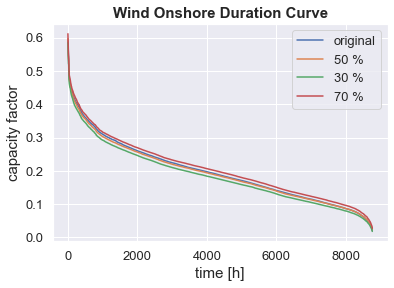

In [502]:
onwind_o_duration = pd.Series(np.sort(onwind_o)[::-1])
onwind_50_duration = pd.Series(np.sort(onwind50)[::-1])
onwind_30_duration = pd.Series(np.sort(onwind30)[::-1])
onwind_70_duration = pd.Series(np.sort(onwind70)[::-1])
onwind_duration = pd.concat([onwind_o_duration, onwind_50_duration, onwind_30_duration, onwind_70_duration], axis=1)
onwind_duration.set_axis(["original", "50 %", "30 %", "70 %"], axis=1, inplace=True)


onwind_duration.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time [h]", fontsize=15)
plt.title("Wind Onshore Duration Curve", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/wind_onshore_duration.png", bbox_inches="tight")
plt.show()

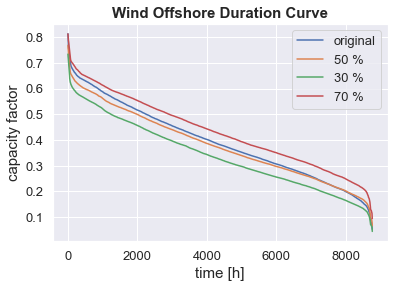

In [503]:
offwind_o_duration = pd.Series(np.sort(offwind_o)[::-1])
offwind_50_duration = pd.Series(np.sort(offwind50)[::-1])
offwind_30_duration = pd.Series(np.sort(offwind30)[::-1])
offwind_70_duration = pd.Series(np.sort(offwind70)[::-1])
offwind_duration = pd.concat([offwind_o_duration, offwind_50_duration, offwind_30_duration, offwind_70_duration], axis=1)
offwind_duration.set_axis(["original", "50 %", "30 %", "70 %"], axis=1, inplace=True)


offwind_duration.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time [h]", fontsize=15)
plt.title("Wind Offshore Duration Curve", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/wind_offshore_duration.png", bbox_inches="tight")
plt.show()

#### Total

C:\Users\Thomas\AppData\Local\Temp/ipykernel_14892/844661941.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Thomas\AppData\Local\Temp/ipykernel_14892/844661941.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Thomas\AppData\Local\Temp/ipykernel_14892/844661941.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Thomas\AppData\Local\Temp/ipykernel_14892/844661941.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_

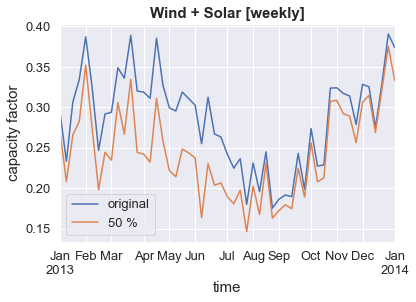

In [504]:
total_o = capfacts.mean(axis=1)
total30 = capfacts_pred_q30_clipped.mean(axis=1)
total40 = capfacts_pred_q40_clipped.mean(axis=1)
total50 = capfacts_pred_q50_clipped.mean(axis=1)
total60 = capfacts_pred_q60_clipped.mean(axis=1)
total70 = capfacts_pred_q70_clipped.mean(axis=1)

total = pd.concat([total_o, total50], axis=1)
total.set_axis(["original", "50 %"], axis=1, inplace=True)
total["Datetime"] = pd.to_datetime(capfacts.snapshot, format="%Y-%m-%d %H:%M:%S")
total.set_index("Datetime", inplace=True)

total_daily = total.resample(rule="W").mean()
total_daily.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time", fontsize=15)
plt.title("Wind + Solar [weekly]", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/total_weekly.png", bbox_inches="tight")
plt.show()

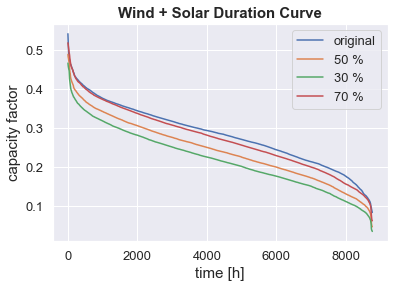

In [505]:
total_o_duration = pd.Series(np.sort(total_o)[::-1])
total_50_duration = pd.Series(np.sort(total50)[::-1])
total_30_duration = pd.Series(np.sort(total30)[::-1])
total_70_duration = pd.Series(np.sort(total70)[::-1])
total_duration = pd.concat([total_o_duration, total_50_duration, total_30_duration, total_70_duration], axis=1)
total_duration.set_axis(["original", "50 %", "30 %", "70 %"], axis=1, inplace=True)


total_duration.plot.line()
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.ylabel("capacity factor", fontsize=15)
plt.xlabel("time [h]", fontsize=15)
plt.title("Wind + Solar Duration Curve", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.savefig("results/plots/total_duration.png", bbox_inches="tight")
plt.show()


### Capacity Factor Scores

In [506]:
scores = pd.read_csv("results/scores_default.csv", index_col=0)
scores

,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,BE0 0 onwind,...,RS0 0 solar,SE4 0 offwind-ac,SE4 0 offwind-dc,SE4 0 onwind,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
Metric,,,,,,,,,,,,,,,,,,,,,
RMSE,0.050804,0.026913,0.057449,0.038160,0.048020,0.017360,0.051495,0.041656,0.055211,0.037322,...,0.050008,0.067573,0.114872,0.042001,0.055080,0.009434,0.014584,0.055730,0.049193,0.049849
RMSE_clipped,0.050804,0.026913,0.057426,0.038157,0.048005,0.017360,0.051458,0.041656,0.055211,0.037322,...,0.049994,0.067573,0.114872,0.042001,0.055061,0.009434,0.014584,0.055714,0.049190,0.049829
MAE,0.030652,0.016851,0.032054,0.026140,0.026922,0.010407,0.028661,0.026586,0.032362,0.026115,...,0.027545,0.054436,0.090988,0.031449,0.030514,0.004502,0.009528,0.030861,0.032823,0.027714
MAE_clipped,0.030650,0.016845,0.031692,0.026137,0.026694,0.010407,0.028202,0.026585,0.032362,0.026114,...,0.027288,0.054436,0.090988,0.031449,0.030203,0.004501,0.009523,0.030563,0.032795,0.027454
NLL,-2.363303,-2.836191,-2.973177,-2.248328,-3.269157,-3.277351,-3.090649,-1.967397,-1.950351,-2.114738,...,-3.166694,-1.325650,-0.828834,-1.902591,-2.906602,-4.355512,-3.276324,-2.937682,-2.055791,-3.022824
PL 0.4,0.014406,0.007981,0.015304,0.012449,0.012867,0.004741,0.013712,0.013059,0.015838,0.012289,...,0.013168,0.025962,0.043403,0.014484,0.014266,0.002076,0.004420,0.014622,0.014856,0.013077
PL 0.4_clipped,0.014405,0.007976,0.015097,0.012447,0.012739,0.004741,0.013462,0.013024,0.015837,0.012289,...,0.013015,0.025962,0.043403,0.014484,0.014082,0.002054,0.004411,0.014447,0.014837,0.012933
PL 0.6,0.015196,0.008268,0.015600,0.012839,0.013153,0.005297,0.013954,0.013006,0.015709,0.012982,...,0.013465,0.026443,0.044252,0.015888,0.015192,0.002327,0.004804,0.015126,0.016825,0.013616
PL 0.6_clipped,0.015195,0.008267,0.015458,0.012838,0.013050,0.005297,0.013756,0.013006,0.015709,0.012981,...,0.013370,0.026443,0.044252,0.015888,0.015070,0.002327,0.004804,0.015004,0.016814,0.013510


In [507]:
scores_solar = filter_by_energy_type(scores, EnergyType.SOLAR).mean(axis=1)
scores_onwind = filter_by_energy_type(scores, EnergyType.ONWIND).mean(axis=1)
scores_offwind = filter_by_energy_type(scores, EnergyType.OFFWIND).mean(axis=1)
scores_total = scores.mean(axis=1)

scores_df = pd.concat([scores_solar, scores_onwind, scores_offwind, scores_total], axis=1)
scores_df.set_axis(["Solar", "Onwind", "Offwind", "Total"], axis=1, inplace=True)
scores_df.set_index(scores.index)

,Solar,Onwind,Offwind,Total
Metric,,,,
RMSE,0.051338,0.026672,0.112920,0.069162
RMSE_clipped,0.051319,0.026671,0.112920,0.069157
MAE,0.028490,0.018709,0.083355,0.047980
MAE_clipped,0.028245,0.018708,0.083354,0.047906
NLL,-3.128820,-2.605036,-1.232454,-2.200063
PL 0.4,0.013513,0.008757,0.039716,0.022796
PL 0.4_clipped,0.013371,0.008754,0.039714,0.022752
PL 0.6,0.013964,0.009326,0.040611,0.023463
PL 0.6_clipped,0.013865,0.009325,0.040611,0.023433


In [508]:
scores_df.to_csv("results/scores_default_thesis.csv")

### Energy System Analysis

In [509]:
no = pypsa.Network("resources/pypsa/results/networks/elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc")
n4 = pypsa.Network("resources/pypsa/results/networks/elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc")
n6 = pypsa.Network("resources/pypsa/results/networks/elec_s_37_q60_ec_lv1.0_Co2L0.0-1H.nc")
n3 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q30_ec_lv1.0_Co2L0.0-1H.nc")
n35 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q35_ec_lv1.0_Co2L0.0-1H.nc")
n45 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q45_ec_lv1.0_Co2L0.0-1H.nc")
n55 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q55_ec_lv1.0_Co2L0.0-1H.nc")
n65 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q65_ec_lv1.0_Co2L0.0-1H.nc")
n5 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q50_ec_lv1.0_Co2L0.0-1H.nc")
n7 = pypsa.Network("resources/pypsa/my_results/elec_s_37_q70_ec_lv1.0_Co2L0.0-1H.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 19, 2].

INFO:pypsa.io:Imported network elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 19, 2].

INFO:pypsa.io:Imported network elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the relea

### Used original network

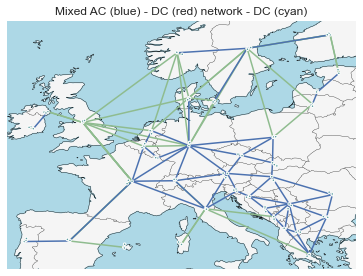

In [510]:
lines_current_type = no.lines.bus0.map(no.buses.carrier)

no.plot(
    line_colors=lines_current_type.map(lambda ct: "r" if ct == "DC" else "b"),
    title="Mixed AC (blue) - DC (red) network - DC (cyan)",
    color_geomap=True,
    jitter=0.3,
)
plt.tight_layout()
plt.savefig("results/plots/no_network.png")

### Total System costs

In [522]:
cost_o = pd.Series(no.objective + no.objective_constant)
cost3 = pd.Series(n3.objective + n3.objective_constant)
cost35 = pd.Series(n35.objective + n35.objective_constant)
cost4 = pd.Series(n4.objective + n4.objective_constant)
cost45 = pd.Series(n45.objective + n45.objective_constant)
cost5 = pd.Series(n5.objective + n5.objective_constant)
cost55 = pd.Series(n55.objective + n55.objective_constant)
cost6 = pd.Series(n6.objective + n6.objective_constant)
cost65 = pd.Series(n65.objective + n65.objective_constant)
cost7 = pd.Series(n7.objective + n7.objective_constant)

cost = pd.DataFrame([cost3, cost35, cost4, cost45, cost_o, cost5, cost55, cost6, cost65, cost7])
cost.set_axis(["30 %", "35 %", "40 %", "45 %", "original", "50 %", "55 %", "60 %", "65 %", "70 %"], axis="index", inplace=True)
cost.set_axis(["Cost"], inplace=True, axis=1)

cost

,Cost
30 %,1.819825e+11
35 %,1.760812e+11
40 %,1.705997e+11
45 %,1.654762e+11
original,1.663325e+11
50 %,1.605450e+11
55 %,1.558937e+11
60 %,1.514794e+11
65 %,1.472089e+11
70 %,1.429839e+11


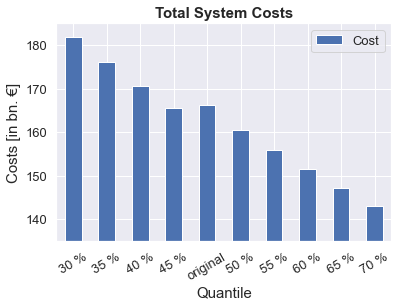

<Figure size 432x288 with 0 Axes>

In [528]:
cost_scaled = cost.divide(1e9)
cost_scaled.plot.bar()
plt.xticks(fontsize=13, rotation=30)
plt.yticks(fontsize=13)
plt.ylim(135, 185)
plt.ylabel("Costs [in bn. €]", fontsize=15)
plt.xlabel("Quantile", fontsize=15)
plt.title("Total System Costs", fontsize=15, fontweight="bold")
plt.legend(fontsize=13)
plt.show()
plt.savefig("results/plots/total_cost.png", bbox_inches="tight")
plt.show()

no.generators.marginal_cost

### Optimal Capacities
Capacity = Maximum power output of a generator?
If a capacity factor is higher, the capacity can be lower to generate the same electric energy
Lower costs because of lower installed power and marginal costs of renewable is small

In [530]:
def get_result(n):
    RE = ['solar','onwind','offwind-ac','offwind-dc']
    result = n.generators.groupby("carrier").sum().p_nom_opt
    result["offwind"] = result["offwind-ac"]+result["offwind-dc"]

    RE = ['solar','onwind','offwind']
    result = result[RE]
    result.index = ['solar','onshore wind','offshore wind']

    return result

In [552]:
result_o = get_result(no)/1e3
result_4 = get_result(n4)/1e3
result_6 = get_result(n6)/1e3
result_3 = get_result(n3)/1e3
result_35 = get_result(n35)/1e3
result_45 = get_result(n45)/1e3
result_5 = get_result(n5)/1e3
result_55 = get_result(n55)/1e3
result_65 = get_result(n65)/1e3
result_7 = get_result(n7)/1e3

capacities = pd.DataFrame([result_3, result_35, result_4, result_45, result_o, result_5, result_55, result_6, result_65, result_7])
# capacities = pd.DataFrame([result_35, result_4, result_45, result_o, result_5, result_55, result_6, result_65])
capacities.set_axis(["30 %", "35 %", "40 %", "45 %", "original", "50 %", "55 %", "60 %", "65 %", "70 %"], axis="index", inplace=True)
# capacities.set_axis(["35 %", "40 %", "45 %", "original", "50 %", "55 %", "60 %", "65 %"], axis="index", inplace=True)
capacities.index.name ="p_nom_opt"
# capacities.set_axis([""], inplace=True, axis=1)

capacities

,solar,onshore wind,offshore wind
p_nom_opt,,,
30 %,560.023811,590.536168,166.716142
35 %,546.015610,543.386654,176.468964
40 %,525.452958,474.533365,201.217235
45 %,499.958061,411.418231,226.592820
original,445.027122,528.677574,170.788512
50 %,476.932785,376.948285,236.878860
55 %,455.510031,365.984534,234.125338
60 %,437.166373,353.863844,231.328611
65 %,421.725835,343.936185,228.217012


In [550]:
capacities["solar"]

p_nom_opt
35 %        546.015610
40 %        525.452958
45 %        499.958061
original    445.027122
50 %        476.932785
55 %        455.510031
60 %        437.166373
65 %        421.725835
Name: solar, dtype: float64

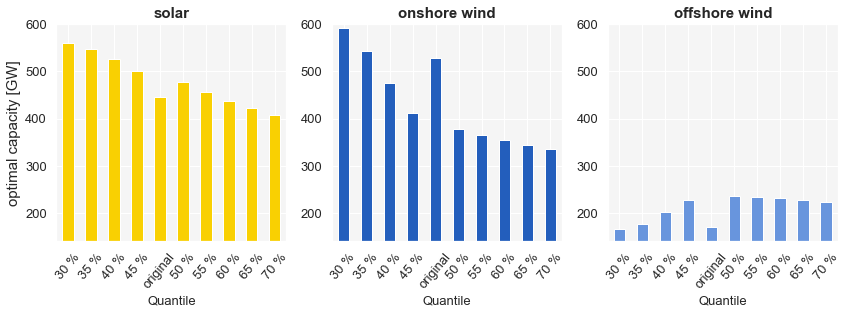

In [583]:
fig, ax = plt.subplots(1,3, figsize=(14,4))


for ax_i in [ax[0], ax[1], ax[2]]:
    ax_i.set_facecolor("whitesmoke")
    ax_i.set_ylim([140, 600])



RE = ['solar','onwind','offwind-ac']
capacities["solar"].plot.bar(color=no.carriers.loc["solar"].color, ax=ax[0])
capacities["onshore wind"].plot.bar(color=no.carriers.loc["onwind"].color, ax=ax[1])
capacities["offshore wind"].plot.bar(color=no.carriers.loc["offwind-ac"].color, ax=ax[2])
# plt.xlabel("Quantile", fontsize=15)
# plt.xticks(fontsize=13, rotation=30)
# plt.yticks(fontsize=13)

for ax_i in [ax[0], ax[1], ax[2]]:
    ax_i.tick_params(axis='x', labelsize=13, rotation=50)
    ax_i.tick_params(axis='y', labelsize=13)
    ax_i.set_xlabel("Quantile", fontsize=13)


ax[0].set_ylabel("optimal capacity [GW]", fontsize=15)

ax[0].set_title("solar", fontsize=15, fontweight="bold")
ax[1].set_title("onshore wind", fontsize=15, fontweight="bold")
ax[2].set_title("offshore wind", fontsize=15, fontweight="bold")
plt.savefig("results/plots/optimal_capacity.png", bbox_inches="tight")
plt.show()